### Instalando PySpark

In [ ]:
!pip3 install pyspark

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Criando Spark Context

In [ ]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql.functions import col

In [ ]:
spark = SparkContext.getOrCreate()

### Carregando Dataset

In [ ]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/data/moviesOnStreamingPlatforms_noOutliers.csv')

In [ ]:
sql_context = SQLContext(spark)
movies_no_outliers_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_noOutliers.csv"), header=True, inferSchema= True)

In [ ]:
movies_no_outliers_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



### MLFlow

In [ ]:
!pip3 install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip3 install mlflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

In [ ]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

/home/jonatas-clementino/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Função que será utilizada para plotar a reta de regressão com os valores da nota real vs nota predita pelo algortimo, a fim de comparar e ter uma ajuda visual do desempenho.

In [ ]:
import matplotlib.pyplot as plt

def plot_comparission_result(y_true, y_pred):
  plt.scatter(y_true, y_pred)
  range = [y_true.min(), y_pred.max()]
  plt.plot(range, range, 'red')
  plt.xlabel('Nota real')
  plt.ylabel('Nota predita')
  plt.show()

Função que calcula o `RMSE`, `MAE` e `R2`.

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

/home/jonatas-clementino/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
warnings.filterwarnings("ignore")
np.random.seed(40)

Função responsável por fazer o treinamento e chamar os métodos acima. Aqui utilizamos o mlflow para guardar os valores dos parametros e os resultados do algortimo.

In [ ]:
def run_experiment_with_model(model, model_name, train_x, train_y, test_x, test_y, params_dict={}):
    # cria um experimento para cada algortimo executado para ajudar na divisão e organização
    experiment_name='MovieIt-'+model_name 
    mlflow.set_experiment(experiment_name=experiment_name)
    with mlflow.start_run():
        model.fit(train_x, train_y)

        predicted_qualities = model.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print(model_name)
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        for param_name, param_value in params_dict.items():
            mlflow.log_param(param_name, param_value)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, model_name, registered_model_name=model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)
            
        plot_comparission_result(test_y, predicted_qualities)

        return r2

### Regressão

Escolhemos a nota do IMDb como target de predição, pelo fato de ser um valor que depende muito do gosto e opinião das pessoas.

##### Preparacao dos dataset para classificacao

Salvamos o dataset que foi processado no Projeto 1, porém houveram alguns problemas quando foram salvos com os dados e tivemos que fazer alguns pre processamentos.

In [ ]:
from pyspark.sql.functions import split

movies_no_outliers_df = (movies_no_outliers_df.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language')
.drop('_c0'))

In [ ]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_no_outliers_df = movies_no_outliers_df.withColumn("Age", translate('Age', '+', ''))
movies_no_outliers_df = movies_no_outliers_df.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

In [ ]:
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [ ]:
movies_no_outliers_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



**One hot enconding**

Vamos explodir o array de gênero, países e línguas e transformá-los em diversas colunas com valores binários para cada filme e juntar essas novas informações a tabela original.

In [ ]:
from pyspark.sql.functions import explode

exploded_genres = movies_no_outliers_df.withColumn('exploded', explode(col('GenresArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_genres.show(5)

+-----+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+
|   ID|Action|Adventure|Animation|Biography|Comedy|Crime|Documentary|Drama|Family|Fantasy|Film-Noir|History|Horror|Music|Musical|Mystery|News|Reality-TV|Romance|Sci-Fi|Short|Sport|Talk-Show|Thriller|War|Western|
+-----+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+
| 3918|     0|        0|        0|        0|     0|    0|          0|    1|     0|      0|        0|      0|     1|    0|      0|      1|   0|         0|      0|     1|    0|    0|        0|       0|  0|      0|
| 3997|     0|        0|        0|        0|     0|    1|          0|    1|     0|      0|        0|      0|     0|    0|      0|      1|   0|         0

In [ ]:
exploded_countries = movies_no_outliers_df.withColumn('exploded', explode(col('CountriesArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_countries.show(5)

+----+-----------+-------+-------+---------+---------+-------+-------+-------+----------+-------+-------+-------+----------------------+------+--------+--------+------+--------------+----+-----+-----+--------+-----+----------+-------+----+------+--------------+--------------+-------+------------------+------------+-----+-------+--------+-------+------+-------+-------+-----+------+---------+-----+-----------------------------+---------+-------+-------+-----+---------+----+----+-------+------+-----+-------+-----+------+-----+----------+-------+-------+-----+---------+----------+------+--------+-----+------+------+----------+-------+-------+-----+-----------+-----------+-------+------+--------+---------+------+----------------+--------+----+-----------+------+--------+-----------+-----+---------------------------+-------+------+------+------------+-------+------+---------+--------+--------+------------+-----------+------------+-----+------+-----------+-----+------+--------+--------+------

In [ ]:
exploded_languages = movies_no_outliers_df.withColumn('exploded', explode(col('LanguagesArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_languages.show(5)

+----+------------------+----------+---------+----+--------+---------+----------------------+-------+----------------+------+---------+-------+--------+--------+--------------------+--------------------+------------------------+------+------+-----+-------+----------------+--------+-------+-----------------------+---------+---------+-------+--------+-------+-------+-----+--------+-----+------+----+-----+----------------+-------+---------+--------+---+--------+-------+-------+------+--------------------+-----+--------+--------+------+-----+-------+--------+-------+-----+--------+--------+------+-----+---------+---------+----------+---------+-----+-------+--------+----------------------+------+-------+-----+-----------+-------+-------+------+------+-------+-----+-------+-------+----------+----------+-------------+----------+-----+---------+-------+--------+--------+-----+----------+-------+----+--------------+-------+------+---------+----+------+------+----+---------------------+---------

In [ ]:
movies_exploded = movies_no_outliers_df.join(exploded_genres, 'ID')
movies_exploded = movies_exploded.join(exploded_countries,'ID')
movies_exploded = movies_exploded.join(exploded_languages,'ID')
movies_exploded.show(5)

+-----+--------------------+----+----+-------+----+-----------+-------+-------+-----------------+--------------------+--------------------+--------------------+---------------------+--------------+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+-----------+-------+-------+---------+---------+-------+-------+-------+----------+-------+-------+-------+----------------------+------+--------+--------+------+--------------+----+-----+-----+--------+-----+----------+-------+----+------+--------------+--------------+-------+------------------+------------+-----+-------+--------+-------+------+-------+-------+-----+------+---------+-----+-----------------------------+---------+-------+-------+-----+---------+----+----+-------+------+-----+-------+-----+------+-----+----------+-------+-------+-----+---------+----------+------+--------+-----+

Vamos dropar as colunas que não queremos que participem das regressões e as colunas com os arrays que acabamos de explodir.

In [ ]:
movies_data = movies_exploded.toPandas()
movies_data = movies_data.drop(['LanguagesArray', 'CountriesArray', 'DirectorsArray', 'GenresArray', 'ID', 'Title'], axis = 1)
movies_data.head(5)

,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,Action,...,Turkmen,Ukrainian,Urdu,Vietnamese,Welsh,Wolof,Xhosa,Yiddish,Yoruba,Zulu
0,2019,5.9,0,1,0,0,105,-1,6.8,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,6.0,0,1,0,0,101,18,1.8,0,...,0,0,0,0,0,0,0,0,0,0
2,2016,6.9,1,0,0,0,107,18,9.3,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,6.5,1,0,1,0,123,13,6.4,0,...,0,0,0,0,0,0,0,0,0,0
4,1992,4.8,0,0,0,1,89,7,4.0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos separar o dataset com as variaveis independentes e target



In [ ]:
X = movies_data.drop('IMDb', axis=1)
y = movies_data['IMDb']

##### Análise de mutual information

Analisaremos agora o mutual information entre as features e target e removeremos todas as features que possuem mutual information de 0.

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

mi = mutual_info_regression(X, y)
mi = pd.Series(mi)
mi.index = X.columns

df = pd.DataFrame(mi, columns=['mutual_information_score'])
no_mutual_information = df[(df['mutual_information_score'] == 0) | (df['mutual_information_score'] == None)]
no_mutual_information_features = no_mutual_information.index
no_mutual_information_features

Index(['Disney+', 'Adventure', 'Animation', 'Music', 'Reality-TV', 'Sci-Fi',
       'Short', 'Thriller', 'Afghanistan', 'Albania',
       ...
       'Tagalog', 'Tamil', 'Thai', 'Tupi', 'Turkmen', 'Urdu', 'Vietnamese',
       'Welsh', 'Yiddish', 'Yoruba'],
      dtype='object', length=162)

In [ ]:
movies_data.shape

(5014, 310)

In [ ]:
movies_data_no_mi = movies_data.drop(no_mutual_information_features, axis = 1)
movies_data_no_mi.shape

(5014, 148)

Removemos entao mais de 150 features que não tinha dependência com nosso target (nota IMDb).

In [ ]:
movies_data = movies_data_no_mi
X = movies_data.drop('IMDb', axis=1)
y = movies_data['IMDb']

#### Separando dados para treinamento e teste

Fazendo uso da função `train_test_split` do `sklean`, iremos separar o dataset para 1/3 de teste e o resto de treinamento.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### Algoritmos

Os scores para todos os algortimos foram bem parecido mostrando que existe uma variância em média de 50% nos dados. Analisando os erros podemos notar uma média de 0.7, o que pode ser considerado algo bom, já que as notas vão de 0 a 10, uma predição com esse erro seria algo bem aceitável.
Já o RMSE, podemos notar que o menor é do algoritmo XXX, isso pode implicar que ele é um bom candidato a ser o melhor dos 4, mas pegando o R2 .... (CONTINUAR)

##### Linear Regression

INFO: 'MovieIt-LinearRegression' does not exist. Creating a new experiment
LinearRegression
  RMSE: 0.6789980933524379
  MAE: 0.522750846929406
  R2: 0.5174392779554156


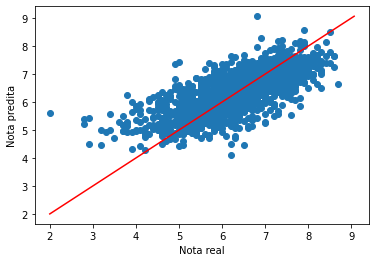

In [ ]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegressionName = 'LinearRegression'

run_experiment_with_model(linearRegression, linearRegressionName, X_train, y_train, X_test, y_test)

##### Decision Tree Regressor

INFO: 'MovieIt-DecisionTreeRegressor' does not exist. Creating a new experiment
DecisionTreeRegressor
  RMSE: 0.9482787714584734
  MAE: 0.71595166163142
  R2: 0.05878916744581186


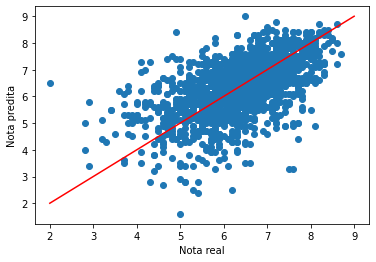

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decisionTree = DecisionTreeRegressor()
decisionTreeName = 'DecisionTreeRegressor'

run_experiment_with_model(decisionTree, decisionTreeName, X_train, y_train, X_test, y_test)

##### MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor

mlpRegressor = MLPRegressor()  
mlpRegressorName = 'MLPRegressor'


run_experiment_with_model(mlpRegressor, mlpRegressorName, X_train, y_train, X_test, y_test)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor()
randomForestName = 'RandomForestRegressor'


run_experiment_with_model(randomForest, randomForestName, X_train, y_train, X_test, y_test)

### Seleção de Hiper Parâmetros

Para seleção dos hiper parâmetros dos algortimos iremos utilizar a ferramenta `optuna`, ela nos permite escolher os hiper parâmetros assim como seus valores para cada iteração.

In [ ]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Hiper parâmetros utilizados:

1. Linear 
2. MLP
    * função de ativação
    * taxa de aprendizado
    * número de épocas
3.  Decision Tree
    * profundidade max da árvore
    * número de amostras para separar o nó interno
4. Random Forest
    * número de árvores
    * profundidade max da árvore






In [ ]:
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['LinearRegression', 'MLPRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor'])
    if regressor_name == 'LinearRegression':
        regressor_obj = LinearRegression()
    if regressor_name == 'MLPRegressor':
        activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        max_iter = trial.suggest_int('max_iter', 150, 200, step=10)
        regressor_obj = MLPRegressor(activation=activation, learning_rate=learning_rate, max_iter=max_iter)
    if regressor_name == 'DecisionTreeRegressor':
        dt_max_depth = trial.suggest_int('max_depth', 1, 32, step=2)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        regressor_obj = DecisionTreeRegressor(max_depth=dt_max_depth, min_samples_split=min_samples_split)
    if regressor_name == 'RandomForestRegressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        rf_max_depth = trial.suggest_int('max_depth', 1, 32, step=2)
        regressor_obj = RandomForestRegressor(n_estimators=n_estimators, max_depth=rf_max_depth)
        
    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective)  # Invoke optimization of the objective function.

[I 2020-11-12 21:10:29,306] A new study created in memory with name: no-name-08059aa3-a94f-419b-ade2-21aa5812bac2
[I 2020-11-12 21:10:29,433] Trial 0 finished with value: 0.5174392779554156 and parameters: {'regressor': 'LinearRegression'}. Best is trial 0 with value: 0.5174392779554156.
[I 2020-11-12 21:10:30,069] Trial 1 finished with value: 0.4981418837347118 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 20, 'max_depth': 29}. Best is trial 0 with value: 0.5174392779554156.
[I 2020-11-12 21:10:30,665] Trial 2 finished with value: 0.476788603865796 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 60, 'max_depth': 5}. Best is trial 0 with value: 0.5174392779554156.
[I 2020-11-12 21:10:30,738] Trial 3 finished with value: 0.13385147192389413 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 19, 'min_samples_split': 3}. Best is trial 0 with value: 0.5174392779554156.
[I 2020-11-12 21:10:32,575] Trial 4 finished with value: 

[I 2020-11-12 21:11:56,396] Trial 36 finished with value: 0.5247827111198209 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 50, 'max_depth': 13}. Best is trial 26 with value: 0.5307850673884333.
[I 2020-11-12 21:11:57,583] Trial 37 finished with value: 0.5290942071636406 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 9}. Best is trial 26 with value: 0.5307850673884333.
[I 2020-11-12 21:11:57,651] Trial 38 finished with value: 0.5174392779554156 and parameters: {'regressor': 'LinearRegression'}. Best is trial 26 with value: 0.5307850673884333.
[I 2020-11-12 21:11:59,676] Trial 39 finished with value: 0.521472704158708 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 70, 'max_depth': 21}. Best is trial 26 with value: 0.5307850673884333.
[I 2020-11-12 21:11:59,756] Trial 40 finished with value: 0.2386591279315643 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 13, 'min_samples_split'

[I 2020-11-12 21:13:22,771] Trial 72 finished with value: 0.5308337422005102 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:13:24,967] Trial 73 finished with value: 0.5276567729198207 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:13:26,286] Trial 74 finished with value: 0.515667538778196 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:13:28,727] Trial 75 finished with value: 0.5298595880840354 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 15}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:13:30,634] Trial 76 finished with value: 0.5296105271923752 and parameters: {'regressor': 'RandomForestRe

[I 2020-11-12 21:14:28,928] Trial 108 finished with value: 0.31276169328166925 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 11, 'min_samples_split': 4}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:14:30,893] Trial 109 finished with value: 0.5309602691024083 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 13}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:14:33,179] Trial 110 finished with value: 0.5311514087747865 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 15}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:14:34,962] Trial 111 finished with value: 0.5332377903777077 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 64 with value: 0.5344978477480806.
[I 2020-11-12 21:14:36,973] Trial 112 finished with value: 0.5313192141474282 and parameters: {'regressor': 'Rand

[I 2020-11-12 21:15:48,304] Trial 144 finished with value: 0.5349921164656888 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:15:50,178] Trial 145 finished with value: 0.5303771071416038 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:15:52,241] Trial 146 finished with value: 0.5282214055963439 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:15:53,263] Trial 147 finished with value: 0.5285880530489344 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 70, 'max_depth': 9}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:15:55,066] Trial 148 finished with value: 0.5278601103929814 and parameters: {'regressor': 'Rando

[I 2020-11-12 21:17:03,472] Trial 179 finished with value: 0.531130286093259 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:17:03,521] Trial 180 finished with value: 0.3209591218348532 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 11, 'min_samples_split': 4}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:17:05,442] Trial 181 finished with value: 0.5326968704559233 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:17:07,697] Trial 182 finished with value: 0.5256343778050737 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 15}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:17:09,795] Trial 183 finished with value: 0.5296482267887757 and parameters: {'regressor': 'R

[I 2020-11-12 21:18:09,124] Trial 214 finished with value: 0.5288243893494096 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:18:10,893] Trial 215 finished with value: 0.5304360526717508 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:18:10,969] Trial 216 finished with value: 0.5174392779554156 and parameters: {'regressor': 'LinearRegression'}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:18:12,700] Trial 217 finished with value: 0.5275425506999736 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:18:14,430] Trial 218 finished with value: 0.5343650493746852 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max

[I 2020-11-12 21:19:07,916] Trial 250 finished with value: 0.5311972776537142 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:19:09,662] Trial 251 finished with value: 0.532365067907284 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:19:11,442] Trial 252 finished with value: 0.006848693339208567 and parameters: {'regressor': 'MLPRegressor', 'activation': 'tanh', 'learning_rate': 'adaptive', 'max_iter': 160}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:19:13,506] Trial 253 finished with value: 0.5291259034148666 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 144 with value: 0.5349921164656888.
[I 2020-11-12 21:19:15,068] Trial 254 finished with value: 0.5287335496655663 and paramete

[I 2020-11-12 21:20:08,483] Trial 285 finished with value: 0.5316004321632393 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:20:10,435] Trial 286 finished with value: 0.5323728953556885 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:20:11,959] Trial 287 finished with value: 0.5280736307194167 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:20:13,676] Trial 288 finished with value: 0.5316360395843573 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:20:15,257] Trial 289 finished with value: 0.5285880237593127 and parameters: {'regressor': 'Rand

[I 2020-11-12 21:21:07,638] Trial 321 finished with value: 0.5312656143544907 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:21:08,924] Trial 322 finished with value: 0.5288504166332337 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:21:10,627] Trial 323 finished with value: 0.5316828895071468 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:21:10,682] Trial 324 finished with value: 0.5174392779554156 and parameters: {'regressor': 'LinearRegression'}. Best is trial 258 with value: 0.5369973926191569.
[I 2020-11-12 21:21:12,781] Trial 325 finished with value: 0.5308076807676231 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'ma

[I 2020-11-12 21:22:14,239] Trial 357 finished with value: 0.5287241790768809 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:22:15,835] Trial 358 finished with value: 0.5332865542208058 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:22:17,250] Trial 359 finished with value: 0.5268384938165273 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:22:18,464] Trial 360 finished with value: 0.5272797879015172 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 70, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:22:20,375] Trial 361 finished with value: 0.534557099687115 and parameters: {'regressor': 'RandomF

[I 2020-11-12 21:23:16,813] Trial 393 finished with value: 0.5244916816766456 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 15}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:23:18,006] Trial 394 finished with value: 0.5139493811695048 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:23:19,552] Trial 395 finished with value: 0.5321718027289433 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:23:21,550] Trial 396 finished with value: 0.528943790773914 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:23:23,338] Trial 397 finished with value: 0.5335921026504957 and parameters: {'regressor': 'RandomF

[I 2020-11-12 21:24:25,776] Trial 429 finished with value: 0.5315237502536498 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:24:25,826] Trial 430 finished with value: 0.38469152008008056 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 9, 'min_samples_split': 7}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:24:27,663] Trial 431 finished with value: 0.5313489714884803 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:24:29,453] Trial 432 finished with value: 0.5303130495131996 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:24:31,194] Trial 433 finished with value: 0.5345459622652351 and parameters: {'regressor': 'R

[I 2020-11-12 21:25:34,744] Trial 464 finished with value: 0.5289266207046526 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:25:36,489] Trial 465 finished with value: 0.5315772082070227 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:25:37,952] Trial 466 finished with value: 0.5253805944701426 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:25:39,756] Trial 467 finished with value: 0.5300952191429175 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:25:40,828] Trial 468 finished with value: 0.5292669365043862 and parameters: {'regressor': 'Rand

[I 2020-11-12 21:26:50,097] Trial 500 finished with value: 0.429283634798584 and parameters: {'regressor': 'MLPRegressor', 'activation': 'relu', 'learning_rate': 'adaptive', 'max_iter': 190}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:26:52,318] Trial 501 finished with value: 0.5334458725576313 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:26:53,800] Trial 502 finished with value: 0.5296554585898154 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:26:55,410] Trial 503 finished with value: 0.527778918909285 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:26:57,406] Trial 504 finished with value: 0.5303303999285662 and parameters: {

[I 2020-11-12 21:28:06,008] Trial 535 finished with value: 0.5256048135213316 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 15}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:28:07,582] Trial 536 finished with value: 0.5285534125463494 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:28:09,119] Trial 537 finished with value: 0.5293702698390463 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:28:10,835] Trial 538 finished with value: 0.5279729763110996 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:28:10,902] Trial 539 finished with value: 0.5174392779554156 and parameters: {'regressor': 'Linea

[I 2020-11-12 21:29:22,759] Trial 571 finished with value: 0.5278281879083541 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:29:24,821] Trial 572 finished with value: 0.5243531862851103 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:29:26,965] Trial 573 finished with value: 0.5316272619551916 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:29:29,645] Trial 574 finished with value: 0.5246169101717788 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:29:32,057] Trial 575 finished with value: 0.5307632926827857 and parameters: {'regressor': 'Rando

[I 2020-11-12 21:30:57,458] Trial 607 finished with value: 0.5307446669075833 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:30:58,227] Trial 608 finished with value: 0.5260732947032103 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 40, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:31:00,010] Trial 609 finished with value: 0.5296443727197966 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:31:01,862] Trial 610 finished with value: 0.5291340429635635 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 13}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:31:03,275] Trial 611 finished with value: 0.526250718557175 and parameters: {'regressor': 'Random

[I 2020-11-12 21:32:08,193] Trial 643 finished with value: 0.52863134648363 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:32:09,530] Trial 644 finished with value: 0.5270815925009424 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 9}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:32:11,043] Trial 645 finished with value: 0.5309607629421069 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:32:12,511] Trial 646 finished with value: 0.5317488503222161 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 11}. Best is trial 350 with value: 0.5395805170449737.
[I 2020-11-12 21:32:13,804] Trial 647 finished with value: 0.5247367685968612 and parameters: {'regressor': 'RandomFore

KeyboardInterrupt: 

Como podemos ver nos logs do optuna o algortimo que apresentou o melhor desempenho, com um `r2 score` de `0.5395805170449737`, foi o `random forest` com os hiper parâmetros `'n_estimators': 100` e  `max_depth': 11`. Sendo assim, utilizaremos ele para tentar melhorar o score e minimizar o erro.

### Diagnóstico de Regressor

Agora iremos calcular o score aumentando o número de features (1 até 147 - número máx de features do dataset) para ver se o score melhora e reduzir o número de dados de treinamento para 60% do dataset utilizando o algoritmo `random forest` com os hiper parâmentros que foram definidos na etapa anterior.

Para isso, ordenamos todos os mutual information em ordem decrescente, para a cada iteração adicionarmos a próxima feature com maior valor de MI.

In [ ]:
with_mutual_information = df[(df['mutual_information_score'] != None) & (df['mutual_information_score'] != 0)]
with_mutual_information = with_mutual_information.sort_values(by='mutual_information_score', ascending=False)
total_features = with_mutual_information.shape[0]
features_ordered = with_mutual_information.index
total_features

147

In [ ]:
best_r2 = 0
best_features_number = 1

for i in range(1,total_features+1):
    print('Running trial with', i, 'features')
    movies_data_trial = movies_data.drop(features_ordered[i:], axis = 1)
    X_trial = movies_data_trial.drop('IMDb', axis=1)
    y_trial = movies_data_trial['IMDb']
    
    X_train, X_test, y_train, y_test = train_test_split(X_trial, y_trial, test_size=0.4, random_state=0)

    r2 = run_experiment_with_model(best_model_ever, randomForestName, X_train, y_train, X_test, y_test)
    
    if r2 > best_r2:
        best_r2 = r2
        best_features_number = i    

Running trial with  1  features
Running trial with  2  features
Running trial with  3  features
Running trial with  4  features
Running trial with  5  features
Running trial with  6  features
Running trial with  7  features
Running trial with  8  features
Running trial with  9  features
Running trial with  10  features
Running trial with  11  features
Running trial with  12  features
Running trial with  13  features
Running trial with  14  features
Running trial with  15  features
Running trial with  16  features
Running trial with  17  features
Running trial with  18  features
Running trial with  19  features
Running trial with  20  features
Running trial with  21  features
Running trial with  22  features
Running trial with  23  features
Running trial with  24  features
Running trial with  25  features
Running trial with  26  features
Running trial with  27  features
Running trial with  28  features
Running trial with  29  features
Running trial with  30  features
Running trial with 

In [ ]:
print(best_r2, best_features_number)

0.5564830831051759 134


Conseguimos obter um `r2 score` de 0.55 com as 134 features com maior mutual information, um ganho de quase 2% comparado a análise anterior feita com todas as 147 features. O erro dela.... (CONTINUAR)